<a href="https://colab.research.google.com/github/biolographer/NanoparticlesSAM/blob/main/sam_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEM particle annotation


In [1]:
!git clone https://github.com/Biolographer/NanoparticlesSAM.git


%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('NanoparticlesSAM/NanoparticlesSAM'))
sys.path.append(module_path)

Cloning into 'NanoparticlesSAM'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 194 (delta 6), reused 1 (delta 0), pack-reused 182 (from 2)
Receiving objects: 100% (194/194), 117.78 MiB | 35.94 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [2]:
from NanoparticlesSAM import *
from particle_seg import *
from particle_loader import *
from plots import plot_seg_mask, plot_rect


In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import torchvision

#%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())


PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True


In [4]:
# installing segment anything model
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ep212gzr
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ep212gzr
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=7bd9d9f285d51db63f9a148417dbdd770627d53a4d842a3d01c86ec614d2cbfd
  Stored in directory: /tmp/pip-ephem-wheel-cache-ykb88q7b/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [5]:
# download weights
# Nanoparticle paper used sam_vit_h_4b8939.pth checkpoint
HOME = os.getcwd()
print("HOME:", HOME)

!mkdir -p {HOME}/weights
if not os.path.exists(f'{HOME}/weights/sam_vit_h_4b8939.pth'):
    !curl -o {HOME}/weights/sam_vit_h_4b8939.pth "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"


HOME: /content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2445M  100 2445M    0     0   191M      0  0:00:12  0:00:12 --:--:--  227M


In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f'available device: "{device}"')


available device: "cuda"


In [7]:
DATA_DIR = 'testdata'
RESULT_DIR = 'results'

if os.path.isdir(RESULT_DIR):
  print('ok')
else:
  !mkdir {RESULT_DIR}

save_path = os.path.join(os.getcwd(),'results')
save_path

if os.path.isdir('testdata'):
  print('ok')
else:
  !mkdir {DATA_DIR}


In [11]:
data_path = os.path.join(os.getcwd(), DATA_DIR)

img_set = Particle_Dataset(root = data_path, device='jeol')
print("Analyzing",img_set.__len__(),'imagens')

img_set.files

Setting "crop banner=True" due to jeol device
Analyzing 2 imagens


['A-2h-01.tif', 'A2h_01.tif']

In [12]:
sam_checkpoint = "weights/sam_vit_h_4b8939.pth"

model_type = "vit_h"

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

print(f'ok... device = {device}')

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


ok... device = cuda


In [13]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=36,
    pred_iou_thresh=0.80,
    stability_score_thresh=0.80,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=350,  # Requires open-cv to run post-processing
)

0/2
Analyzing particle: A-2h-01
1 pixel = 2.0 nm
expected particle diameter = 50 nm
Removed 4 particles near the border.


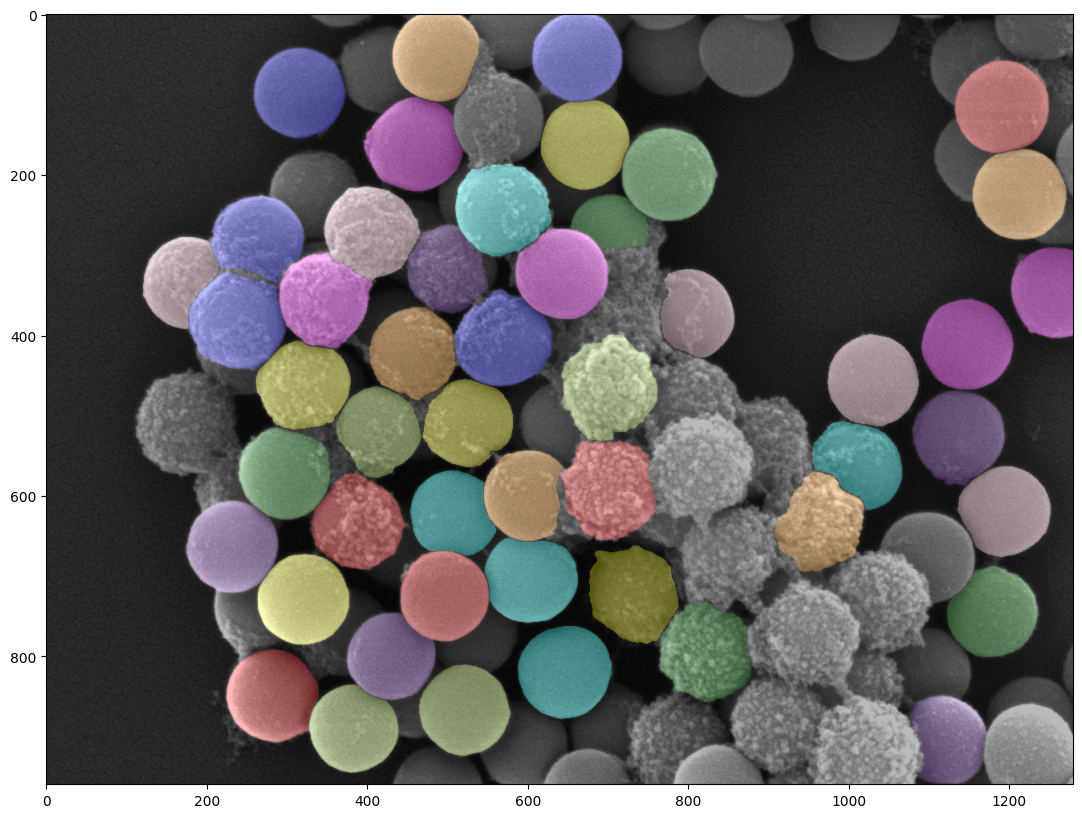

image from A-2h-01 saved!
1/2
Analyzing particle: A2h_01
1 pixel = 1.0 nm
expected particle diameter = 50 nm
Removed 1 particles near the border.


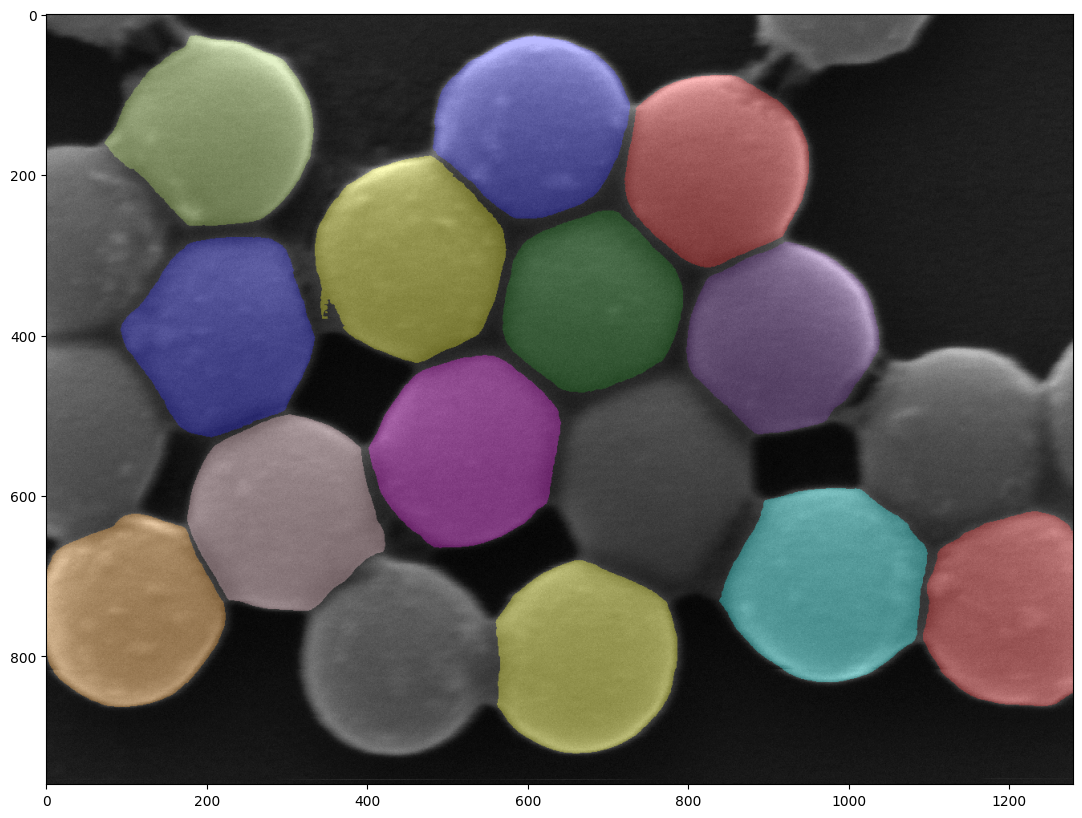

image from A2h_01 saved!


In [24]:
for idx in range(0,img_set.__len__()):

    print(f'{idx}/{img_set.__len__()}')

    #Get image
    img, name, metadata = img_set.__getitem__(idx)
    #img = cv2.imread(f'testdata/{img_set.files[idx]}')
    name = img_set.files[idx]

    if metadata and metadata != {}:
      nm_per_pixel = float(metadata['CM_PIXEL_SIZE'].split('nm')[0])
    else:
      nm_per_pixel = None

    saving_name = name.split('.')[0]
    print(f'Analyzing particle: {saving_name}')
    #Apply the SAM method
    combined_mask, simple_mask, dataframe_SAM = sphere_segmentation(img, mask_generator,
                                                                    nanometer_per_pixel=nm_per_pixel,
                                                                    diameter_cutoff=50,
                                                                    circularity_cutoff = 0.7,
                                                                    border_cutoff=True)
    dataframe_SAM['img_name'] = saving_name
    # dataframe_SAM.to_excel(f'{save_path}/df_SAM_orig_{saving_name}.xlsx')

    #Combine masks
    #comb_mask = get_comb_mask_from_sam(dataframe_SAM)

    #Get properties from the predicted masks
    #sam_df = label_props_SAM(img, combined_mask)
    #sam_df['img_name'] = saving_name

    #Save results
    #sam_df.to_csv(f'{save_path}/df_analyzed_{saving_name}.csv')

    #plot results
    plot_seg_mask(img, combined_mask)

    print(f'image from {saving_name} saved!')

2.0